In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ncvis
import pickle
import os
%load_ext wurlitzer

## Download India News Dataset

In [2]:
data_dir = "news_data"
file_name = "india-news-headlines.csv"
data_path = os.path.join(data_dir, file_name)

In [3]:
!mkdir -p $data_dir
!kaggle datasets download -f $file_name -p $data_dir therohk/india-headlines-news-dataset
!unzip -d $data_dir -u $data_path".zip"

india-news-headlines.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  news_data/india-news-headlines.csv.zip


In [35]:
import unicodedata
import re
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z.!?,()]+", r" ", s)
    return s.strip()

In [36]:
# n_news = 10**4
n_news = 2230807
n_top = 50

df = pd.read_csv(data_path)
df = df[df.headline_category != "unknown"]
df.publish_date = pd.to_datetime(df.publish_date, format="%Y%m%d")
print("Total number of headers:", len(df.index))
top_cat = df.headline_category.value_counts()[:n_top].index.values
df = df[df.headline_category.isin(top_cat)]
print("Top-{} number of headers: {}".format(n_top, len(df.index)))
# df = df.sample(n=n_news, random_state=42).reset_index(drop=True)
# print("Selected number of headers:", len(df.index))
df.headline_category = df.headline_category.astype("category")
df.drop(columns="publish_date", inplace=True)
df.headline_text = df.headline_text.apply(normalize_string)
df = df[df.headline_text != ""].reset_index(drop=True)

Total number of headers: 2763429
Top-50 number of headers: 2230807


In [29]:
print("Most popular topics:")
print(df.headline_category.value_counts())

Most popular topics:
india                                   270958
city.mumbai                             122990
city.delhi                              112651
business.india-business                 107523
city.chandigarh                          99688
city.hyderabad                           86201
city.bengaluru                           84463
entertainment.hindi.bollywood.news       80086
city.lucknow                             77865
city.ahmedabad                           77514
city.pune                                75852
city.kolkata                             73180
city.nagpur                              70099
city.goa                                 68206
city.chennai                             63856
city.patna                               63308
city.jaipur                              45752
sports.icc-world-cup-2015                40056
business.international-business          36085
city.gurgaon                             27950
city.bhubaneswar                       

In [30]:
df

headline_category  \
0                   tech.tech-news   
1                       city.delhi   
2                   city.bengaluru   
3                      city.nagpur   
4                  city.coimbatore   
...                            ...   
2230802  sports.icc-world-cup-2015   
2230803                  city.pune   
2230804             city.ahmedabad   
2230805                city.mumbai   
2230806                city.jaipur   

                                             headline_text  
0                              wns acquires uk firm for mn  
1        jnu professor held after cops file more firs f...  
2                       youths brainstorm at social summit  
3                         nu engg dean pro vc in ugly spat  
4                        decomposed bodies of lovers found  
...                                                    ...  
2230802          jakati to remain with chennai super kings  
2230803   fda launches crackdown on high performance drugs  
2230804                                          man duped  
2230805  antop hill government colony set to kick off c...  
2230806     held with k beauty cream packs on thar express  

[2230807 rows x 2 columns]

In [31]:
file_name = "wiki-news-300d-1M.vec"
!wget -nc -P $data_dir https://dl.fbaipublicfiles.com/fasttext/vectors-english/$file_name".zip"
data_path = os.path.join(data_dir, file_name)
!unzip -d $data_dir -u $data_path".zip"

File ‘news_data/wiki-news-300d-1M.vec.zip’ already there; not retrieving.

Archive:  news_data/wiki-news-300d-1M.vec.zip


In [48]:
def seq2ind(seq, word2index):
    return [word2index[w] for w in seq]
  
def seq2words(ind_seq, index2word):
    return [index2word[x] for x in ind_seq]

def words2sent(words):
    return " ".join([w for w in words])

def ind2sent(ind_seq, index2word):
    return words2sent(seq2words(ind_seq, index2word))

In [49]:
import time
def load_vec(emb_path, max_words=-1):
    vectors = []
    word2id = {}
    it = 0
    with open(emb_path) as f:
        nvec, ndim = [int(k) for k in f.readline().split()]
        print('Number of vectors:', nvec)
        print('Number of dimensions:', ndim)
        ping = time.time()
        nread = 0
        for line in f:
            nread += 1
            if max_words != -1 and it > max_words:
                break
            it += 1
            orig_word, vect = line.rstrip().split(" ", 1)
            
            word = normalize_string(orig_word)
            vect = np.fromstring(vect, sep=" ")
       
            # Words are sorted by frequency, no need to add less 
            # frequent version of the same word  
            if not (word in word2id):
                vectors.append(vect)
                word2id[word] = len(word2id)
            
            pong = time.time()
            if pong-ping > 5:
                ping = time.time()
                print("Read: {:.2f}%".format(nread/nvec*100))
  
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [50]:
class Aggregator:
    """Builds sentence representation given words encodings. 
    """
    def __init__(self, path, max_words=-1):
        """
        Arguments: 
        path      -- path to file with embeddings (str)
        max_words -- maximum number of embeddings to load (sorted by frequency)
        """   
        self.emb = {}
        self.id2word = {}
        self.word2id = {}
        self.emb, self.id2word, self.word2id = load_vec(path, max_words)
        self.dim = self.emb.shape[1]
            
        self.cache = {}
        
    def embed_word(self, word):
        if word in self.cache:
            return self.cache[word]
        else:
            # Handle unknown
            if word in self.word2id:
                vec = self.emb[self.word2id[word]]
                self.cache[word] = vec
            else:
                vec = np.zeros(self.dim)
            return vec
    
    def embed_sent(self, sent):
        return self.embed_seq(sent.split())
    
    def embed_seq(self, seq):
        enc = np.array([self.embed_word(w) for w in seq])
        return np.mean(enc, axis=0)

In [63]:
agg_path = os.path.join(data_dir, "aggregator")
try:
    with open(agg_path, 'rb') as f:
        agg = pickle.load(f)
except:
    agg = Aggregator(data_path, max_words=-1)
    with open(agg_path, 'wb') as f:
        pickle.dump(agg, f)

In [23]:
vec_path = os.path.join(data_dir, "news_vectors")
try:
    df = pd.read_pickle(vec_path)
except:
    df['vector'] = df.headline_text.apply(agg.embed_sent)
    df.to_pickle(vec_path)

In [24]:
df.head()

headline_category  \
87   entertainment.hindi.bollywood.news   
128             business.india-business   
129                      city.bengaluru   
130                      city.bengaluru   
131                          city.delhi   

                                    headline_text  \
87                                 devdas jinxed?   
128  car dealers caught in bihar sales tax ruling   
129                       he s not so inscrutable   
130           three in race for chief secy s post   
131                        dpcc stages nyay rally   

                                                vector  
87   [-0.0649, -0.0419, -0.06535, -0.0679, -0.1091,...  
128  [-0.0211125, -0.038599999999999995, -0.049475,...  
129  [0.027379999999999998, -0.05566, -0.0492800000...  
130  [0.0060374999999999995, -0.021500000000000005,...  
131  [0.032549999999999996, -0.05925, -0.056075, -0...

In [65]:
X = np.stack(df.vector.values)
y = df.headline_category.cat.codes.values
names = dict(enumerate(df.headline_category.cat.categories))

In [67]:
import ncvis
vis = ncvis.NCVis(n_neighbors=15, M=16, ef_construction=200, n_init_epochs=20,
                  n_epochs=50, min_dist=0.3, n_threads=-1, distance='cosine')

In [68]:
%%time
Ys = vis.fit_transform(X)

CPU times: user 2h 29min 35s, sys: 20.1 s, total: 2h 29min 55s
Wall time: 14min 3s


In [3]:
emb_path = os.path.join(data_dir, "news_emb")
try:
    Ys = np.load(emb_path+".npy")
except:
    np.save(emb_path, Ys)

In [16]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne = TSNE(n_jobs=12)

In [17]:
%%time
Ys = tsne.fit_transform(X)

CPU times: user 3min 42s, sys: 2min 32s, total: 6min 15s
Wall time: 31.5 s


In [20]:
from umap import UMAP
umap = UMAP(n_neighbors=15, min_dist=0.4, metric='correlation', n_epochs=60)

In [22]:
%%capture --no-stdout
%%time
Ys = umap.fit_transform(X)

CPU times: user 12.3 s, sys: 87.8 ms, total: 12.4 s
Wall time: 10.2 s


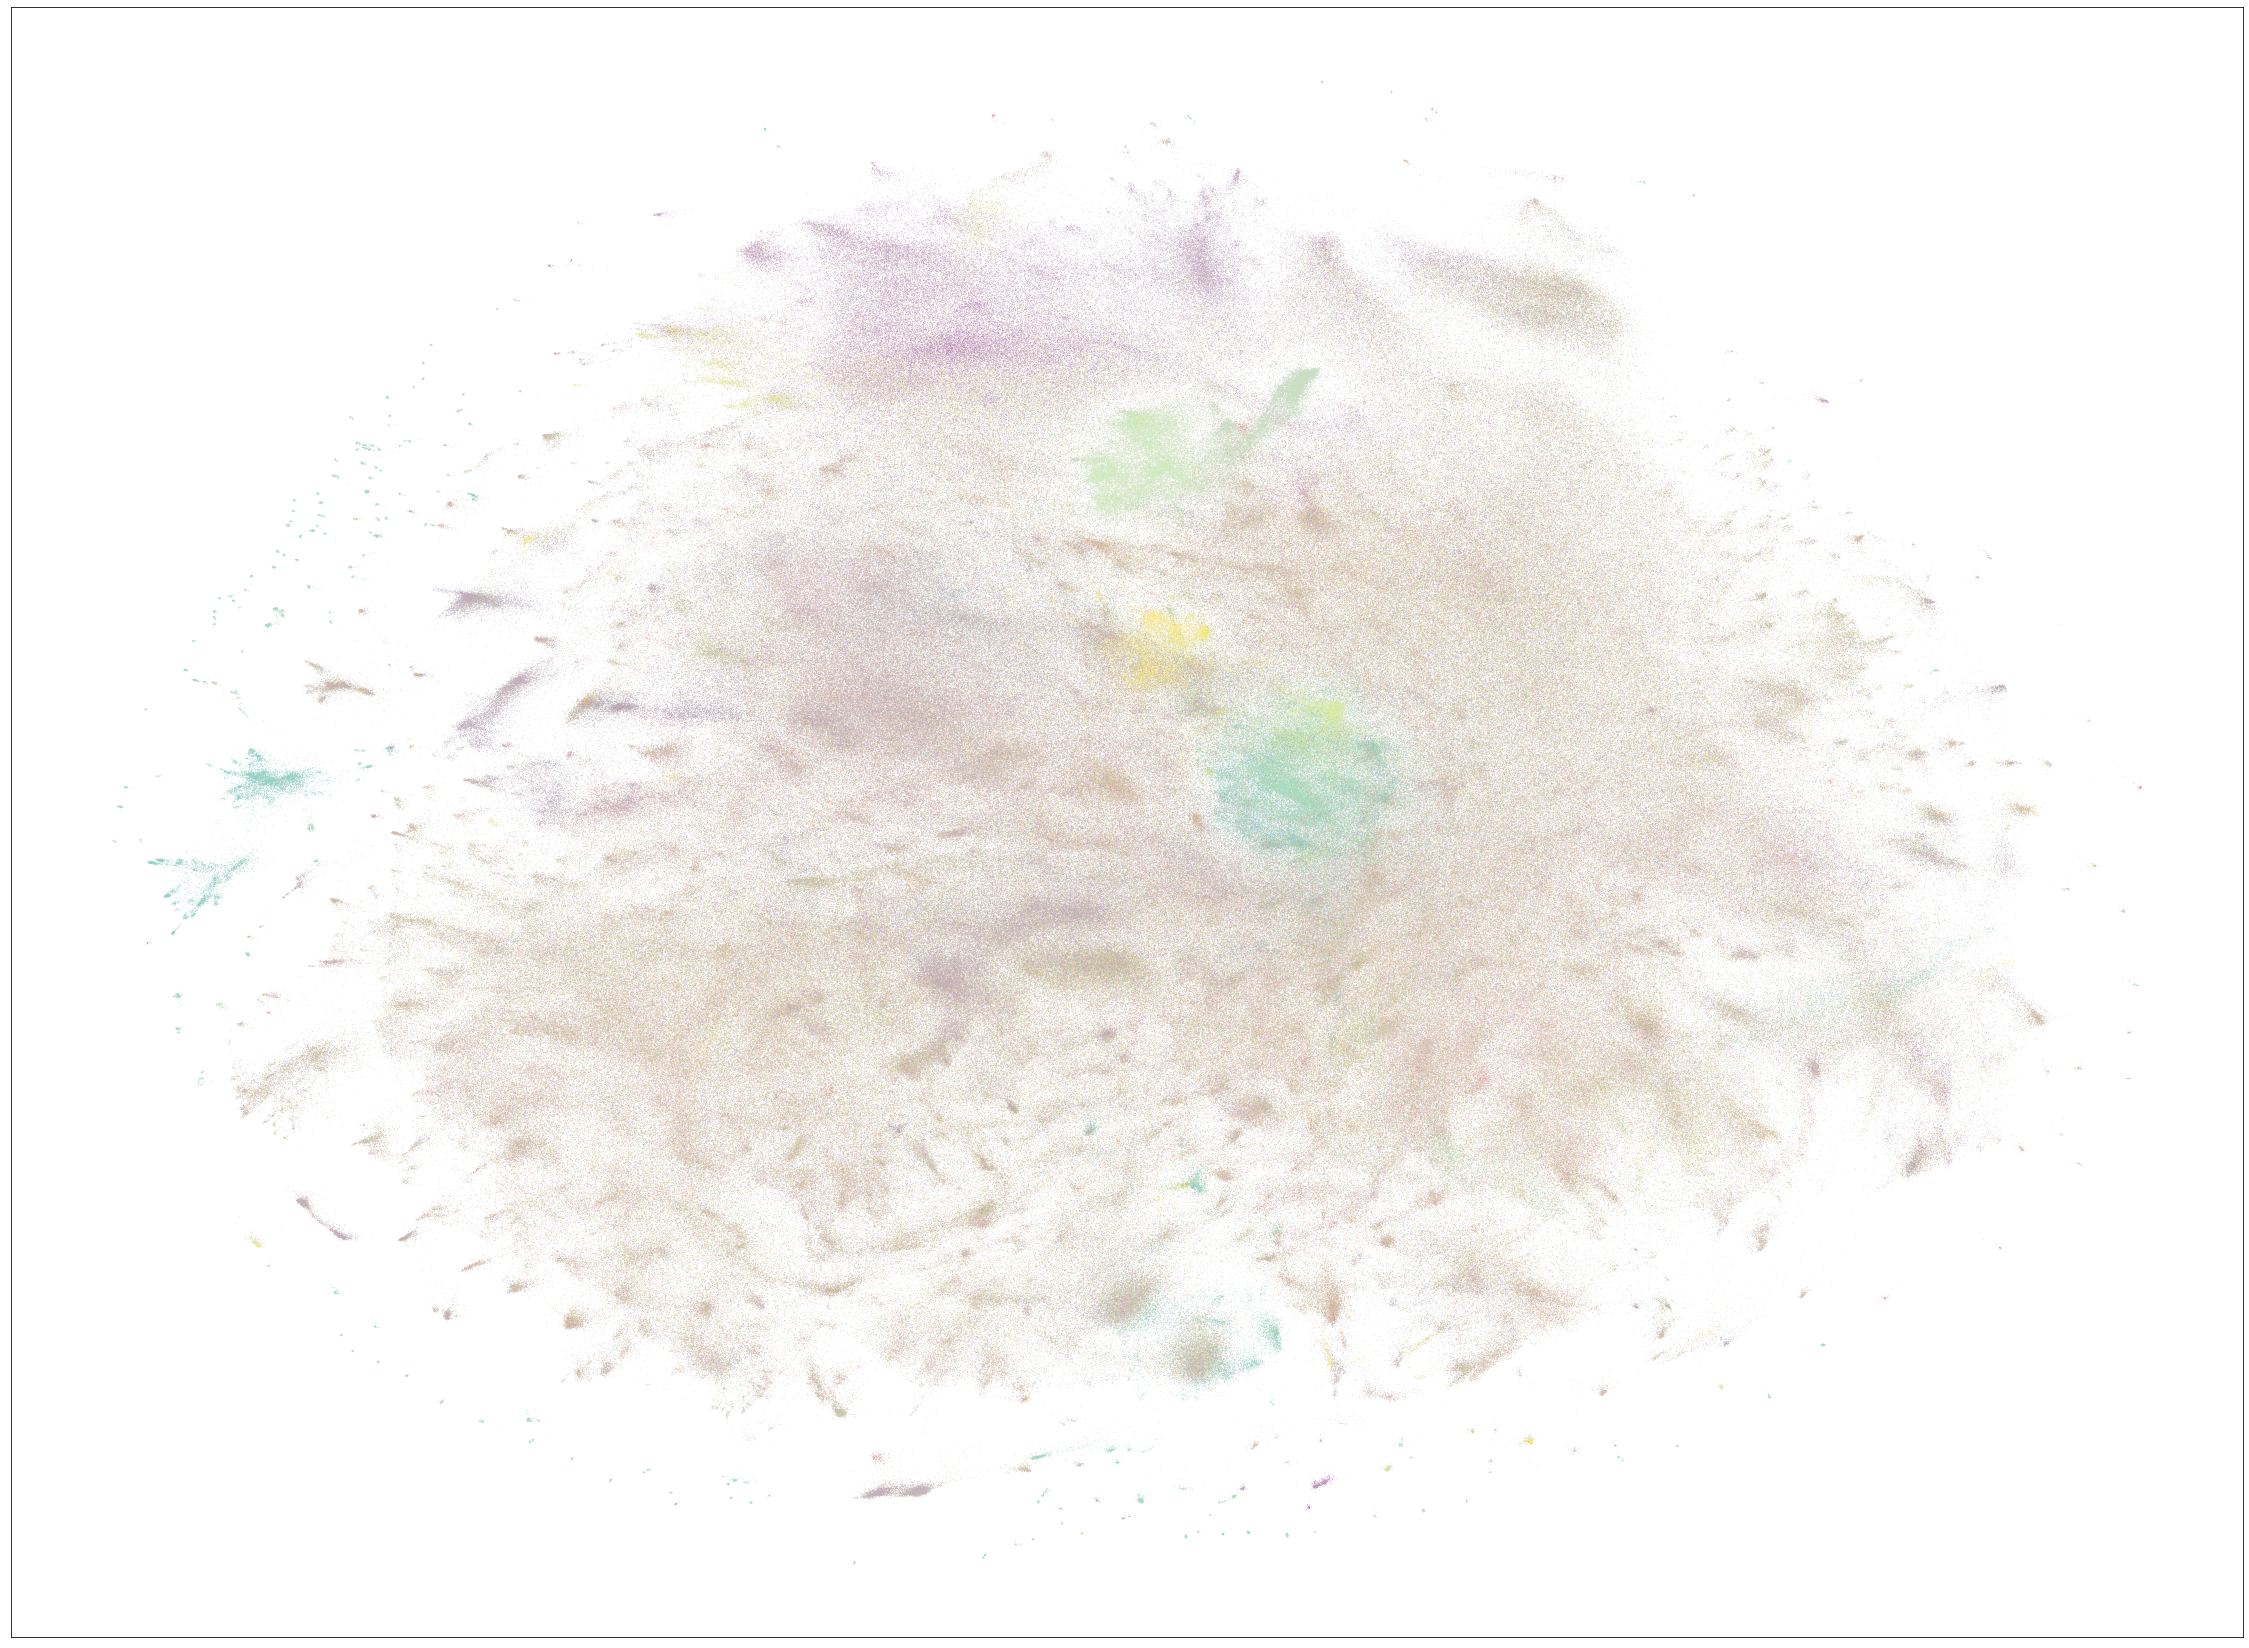

In [91]:
import matplotlib.pyplot as plt
import utils

fig, ax = plt.subplots(1, 1, figsize=(40, 30))
ax.set_xticks([])
ax.set_yticks([])
utils.scatter_classes(Ys, y, ax, marker='.', s=0.05, alpha=0.8,
                      show_labels=False)


# freq_dict = dict(df.headline_category.value_counts())
# total = len(df.index)
# weights = [freq_dict[names[k]]/total for k in np.unique(y)]
# for k in np.unique(y):
#     mean = np.mean(Ys[y == k], axis=0)
#     ax.text(mean[0], mean[1], names[k], horizontalalignment='center', verticalalignment='center', 
#             fontsize=50*weights[k]**0.4, alpha=weights[k]**0.15, stretch='condensed', 
#             rotation=np.random.uniform(-1, 1)*20, bbox=dict(boxstyle="round",
#                    ec=(0., 0., 0.),
#                    fc=ax.collections[k].get_facecolor().squeeze(),
#                    )
#          )
    
plt.show()

In [90]:
fig.savefig('news_2kk.jpg')

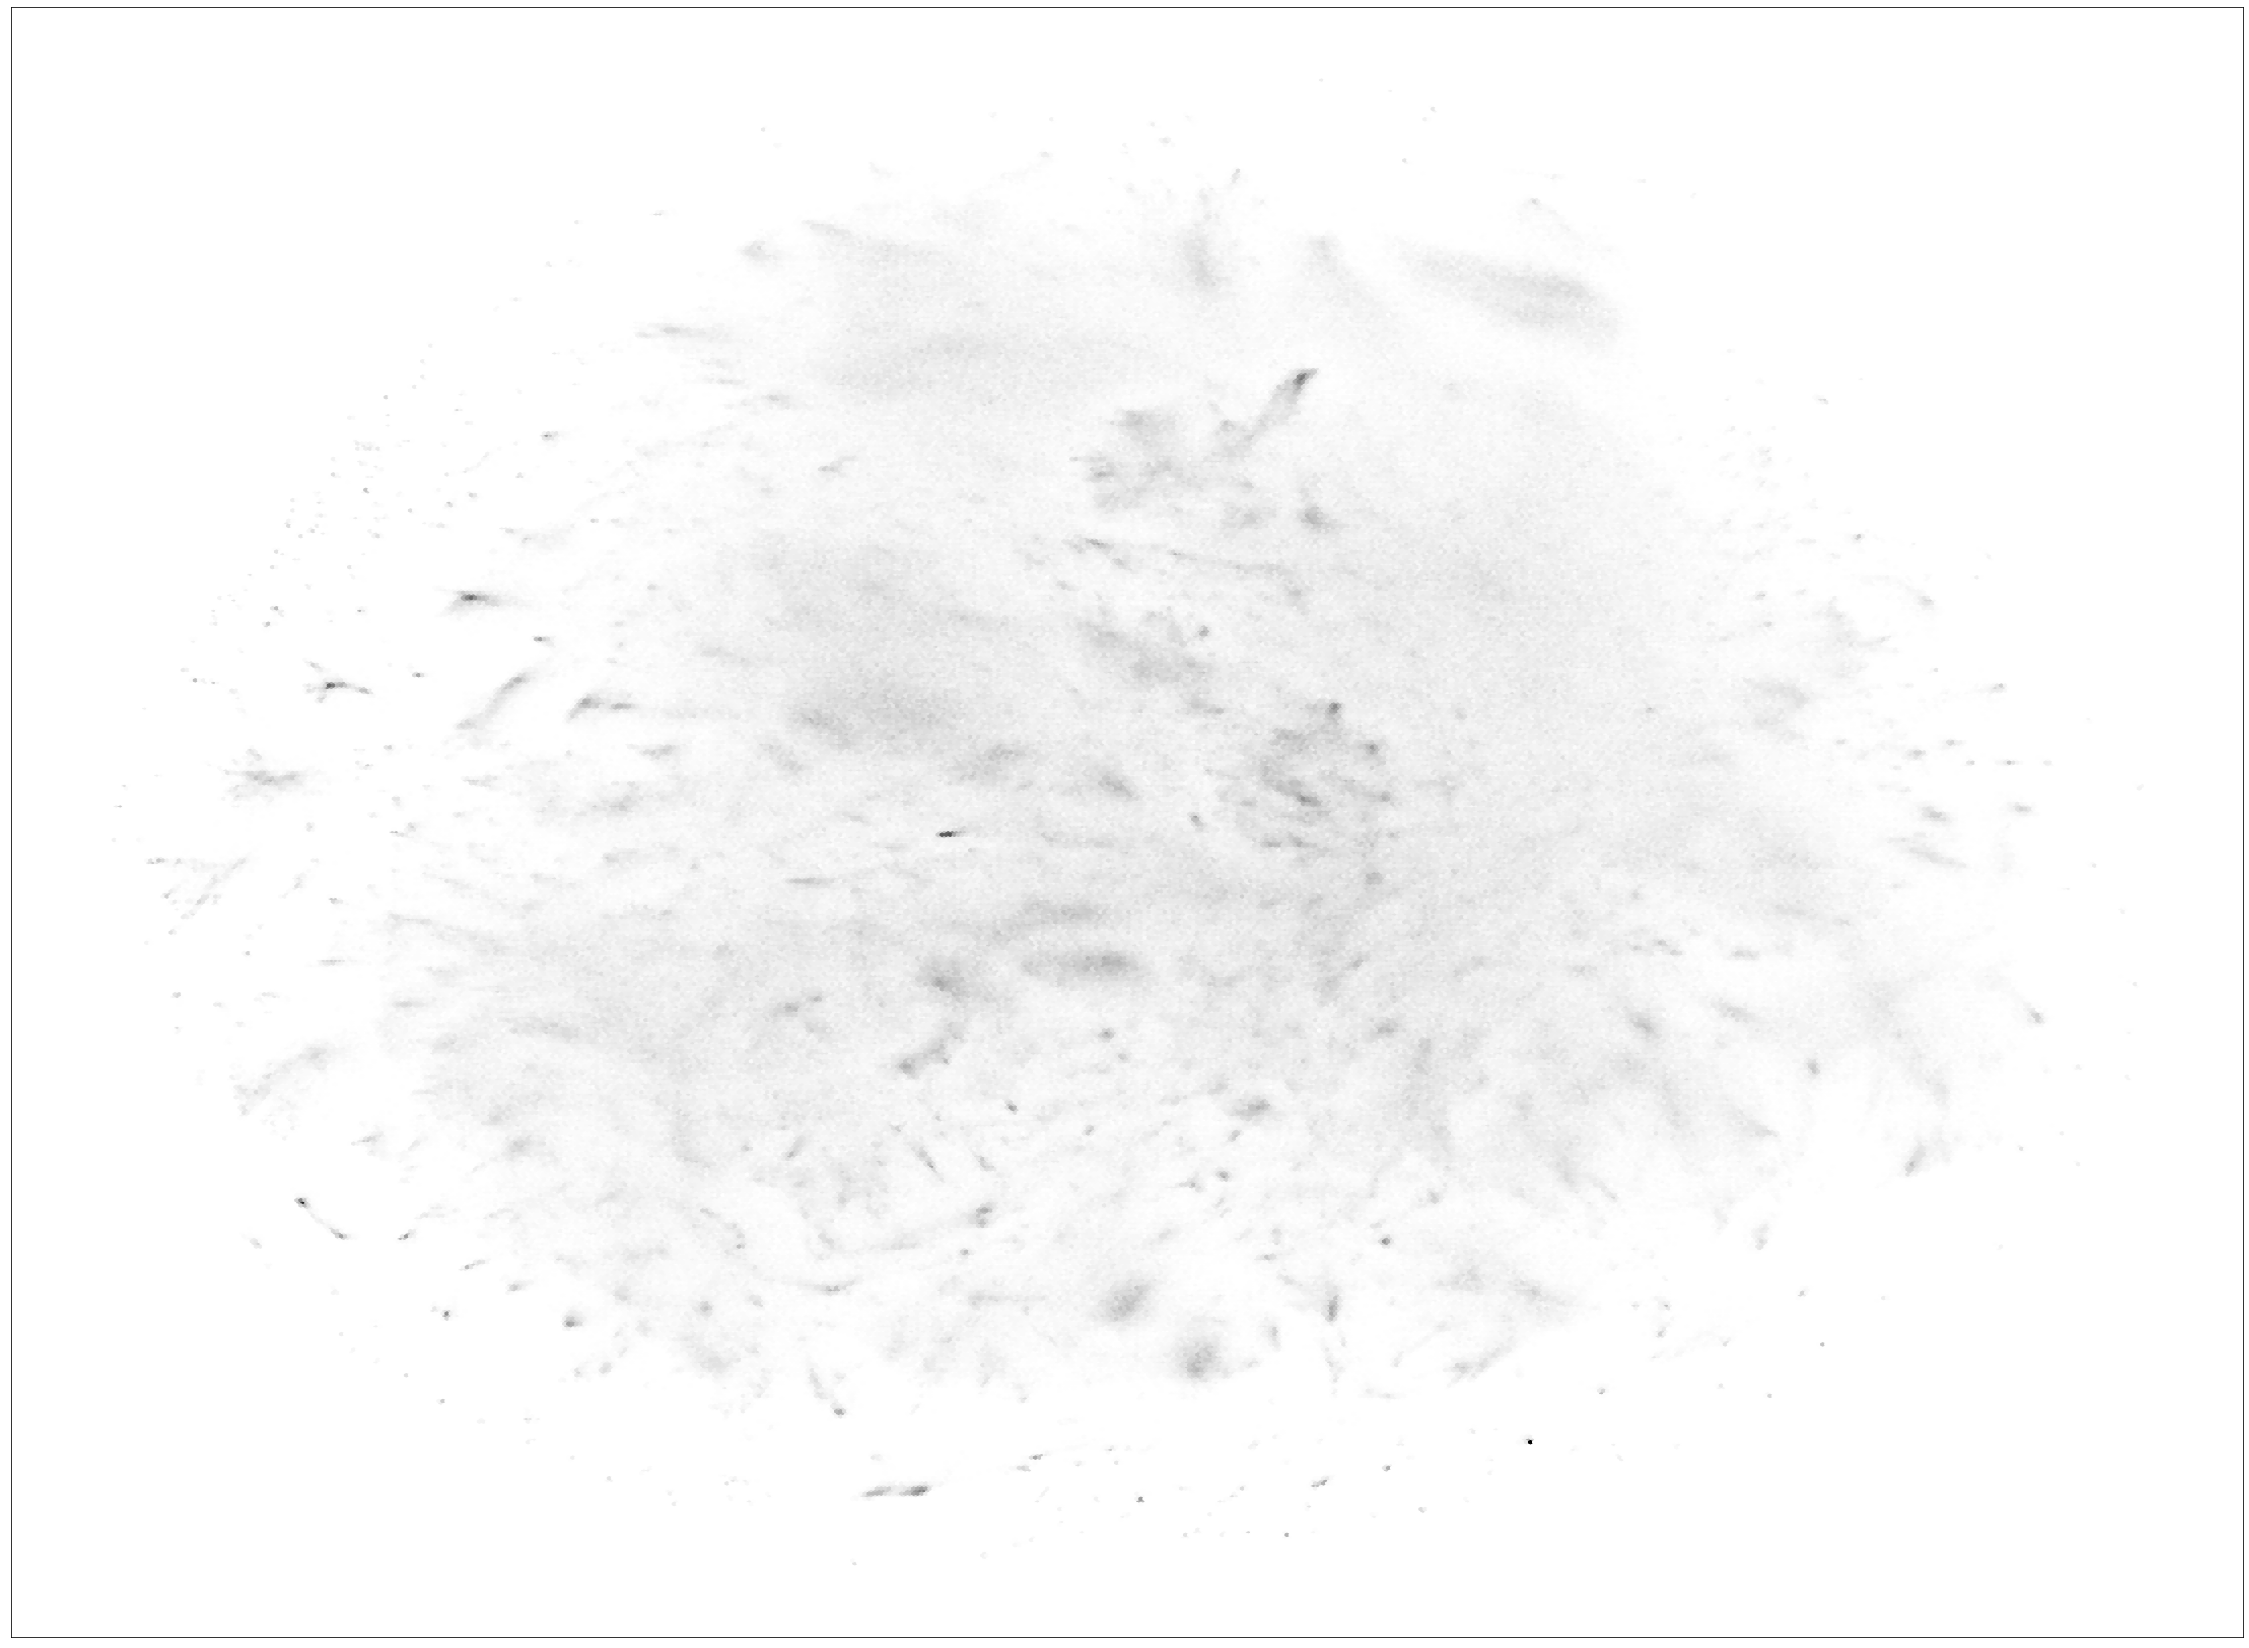

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(40, 30))
ax.set_xticks([])
ax.set_yticks([])
ax.hexbin(Ys[:, 0], Ys[:, 1], gridsize=500, cmap='gray_r')

plt.show()

In [12]:
fig.savefig('news_2kk_hex.jpg')

In [28]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=100).fit(Ys)

mumbai building collapse fearing his clout residents didn t question sena man
indians can t read english
waging war charge didn t stick on militants
don t sacrifice govt for nuke deal bardhan
scratching the surface why your skin med isn t working
eye doc s suspension can t his victims
caste based grave injustice that wasn t
h n crisis won t hesitate to use powers
judges should socialize isolation won t make them unbiased cm parrikar
mopa will come up even if some don t support it cm
govt won t meddle in satyam layoffs
those who resigned in favour of someone don t know about msy s sacrifice
government won t dilute atrocities act cm
india doesn t figure in world top universities
some congmen yet to show up but muttemwar isn t troubled
bhajji can t let hair down
don t go ahead with the nuclear deal cpm tells upa
learning with the times why we don t have hurricanes in india
election commission can t de recognize congress on swamy s petition
cm asks t staffto call off


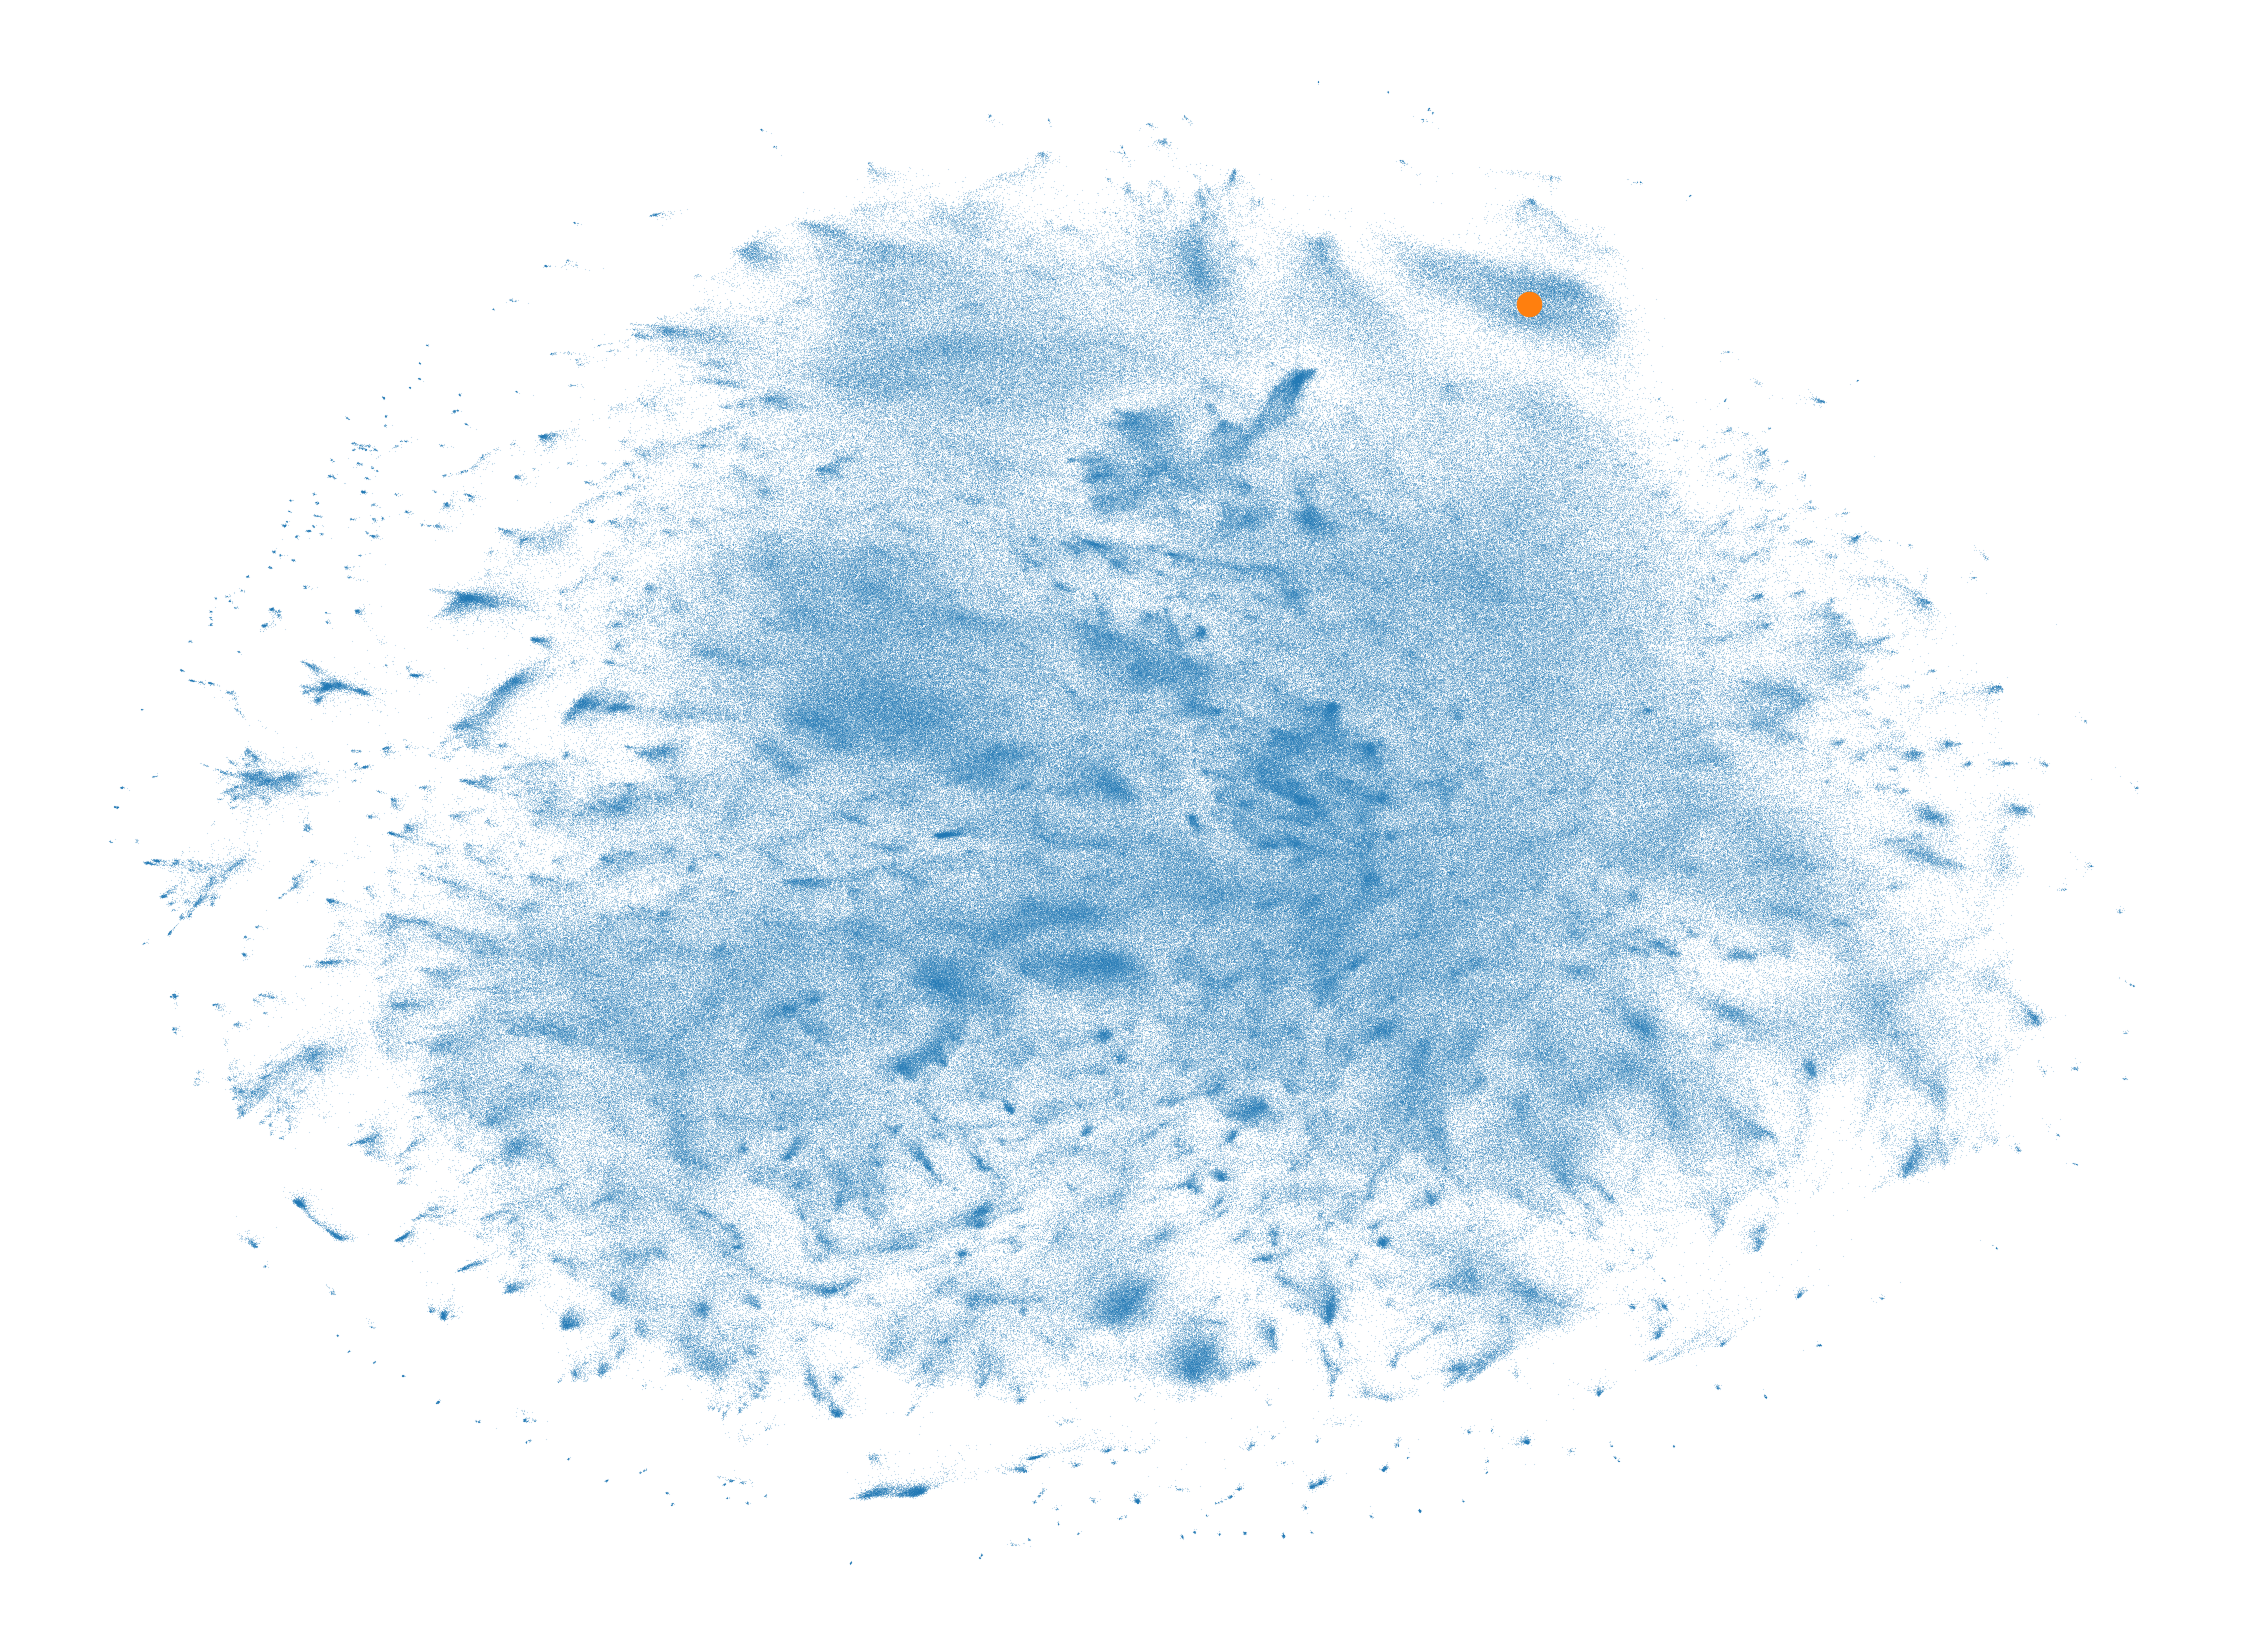

In [37]:
import matplotlib.pyplot as plt
import utils

x_min, x_max = Ys[:, 0].min(), Ys[:, 0].max()
y_min, y_max = Ys[:, 1].min(), Ys[:, 1].max()

px, py = 0.7, 0.85

fig, ax = plt.subplots(1, 1, figsize=(40, 30), frameon=False)
ax.set_axis_off()
ax.scatter(Ys[:, 0], Ys[:, 1], marker='.', s=0.05, alpha=0.8)

x = x_min + px*(x_max-x_min)
y = y_min + py*(y_max-y_min)
ax.scatter(x, y, s=600)

indices = nbrs.kneighbors(np.array([[x, y]]), return_distance=False, n_neighbors=20).ravel()
for i in indices:
    print(df.headline_text[i])
    
plt.show()